In [3]:
import numpy as np
from numpy import ndarray
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from scipy.stats import norm

In [4]:
#changement du dossier par défaut
import os
os.chdir("/Users/guillaume/Desktop/MVA cours/PGM/DM3")

# Traitement des données

In [8]:
données = pd.read_table("german.data-numeric", header=None, delim_whitespace=True)

n, p = données.shape

In [9]:
#X
X = données[list(range(p-1))].astype(float)
X.columns += 1
X = (X - X.mean()) / X.std()
X.insert(0, 0, 1.)


y = données[p-1] - 1  # 0 and 1 instead of 1 and 2
y = 2 * y - 1


In [10]:
X

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1.0,-1.253938,-1.235859,1.343342,-0.733065,1.832252,1.337409,0.449102,1.046463,-1.293076,...,-0.195916,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,0.634131,-0.149908,-0.49975,0.765973
1,1.0,-0.458797,2.247070,-0.503176,0.965893,-0.699357,-0.317800,-0.963168,-0.765594,-1.293076,...,-0.195916,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,0.634131,-0.149908,-0.49975,0.765973
2,1.0,1.131486,-0.738298,1.343342,-0.414510,-0.699357,0.509805,0.449102,0.140434,-1.293076,...,-0.195916,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,0.634131,-0.149908,1.99900,-1.304224
3,1.0,-1.253938,1.749509,-0.503176,1.638398,-0.699357,0.509805,0.449102,1.046463,-0.340885,...,-0.195916,-0.552429,-0.338692,-3.121368,-0.206664,-0.4667,-1.575384,-0.149908,-0.49975,0.765973
4,1.0,-1.253938,0.256825,0.420083,0.576549,-0.699357,-0.317800,0.449102,1.046463,1.563498,...,-0.195916,1.808378,-0.338692,0.320052,-0.206664,-0.4667,-1.575384,-0.149908,-0.49975,0.765973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,1.131486,-0.738298,-0.503176,-0.556090,-0.699357,0.509805,-0.963168,1.046463,-1.293076,...,-0.195916,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,0.634131,-0.149908,1.99900,-1.304224
996,1.0,-1.253938,0.754386,-0.503176,0.222599,-0.699357,-0.317800,-2.375438,1.046463,-0.340885,...,-0.195916,-0.552429,2.949581,0.320052,-0.206664,-0.4667,0.634131,-0.149908,-0.49975,-1.304224
997,1.0,1.131486,-0.738298,-0.503176,-0.874645,-0.699357,1.337409,0.449102,1.046463,0.611307,...,-0.195916,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,0.634131,-0.149908,-0.49975,0.765973
998,1.0,-1.253938,1.998289,-0.503176,-0.520695,-0.699357,-0.317800,0.449102,1.046463,1.563498,...,-0.195916,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,-1.575384,-0.149908,-0.49975,0.765973


#  Algorithme de Gibbs

In [12]:
def normale_tronquée(moyenne, Y):
    """
    Inputs:
    -mean : vecteur
    -Y : vecteur
    
    Outputs:
    -sim : simulations de lois normales tronquées
    """
    p = len(moyenne)
    borne_inf = -moyenne
    borne_sup = -moyenne
    borne_inf[Y < 0] = -np.inf
    borne_sup[Y > 0] = np.inf
    sim = truncnorm.rvs(borne_inf, borne_sup, loc = moyenne, size = (1, p))  
    return result

In [13]:
def beta_sachant_z(z, X, tau = 100):
    '''
    Inputs:
    -z : vecteur 
    -X : matrice des données
    -tau : réel
    
    Ouput:
    -un vecteur de tirage de la loi de beta|z  
    '''
    n, p = X.shape
    
    sigma = X.T.dot(X) + np.eye(p) / tau

    mu = np.linalg.inv(sigma).dot( X.T.dot( z ) )
    mu = np.ravel(mu)   #problème lié aux dimensions
    
    return( np.random.multivariate_normal(mu, np.linalg.inv(sigma)) )  #retourne le vecteur beta actualisé


def Z_sachant_beta_y(beta, X, y):
    '''
    Inputs :
    -beta : vecteur 
    -x : matrice des données
    -y : vecteur
    
    Output : 
    vecteur d'échantillons suivants la loi decz | beta
    '''
    n, p = X.shape
    mu = X.dot(beta)
    return normale_tronquée(mu, y)

In [14]:
def Gibbs(X, y, tau, niter = 4000):
    '''
    Inputs : 
    -X : observations, matrice de taille n*p
    -beta0 : initialisation des betas, vecteur de taille p
    -initialisation des z, vecteur de taille n
    - nombre d'itérations, réel
    
    Outputs : 
    - z : liste des z_i
    - beta : liste des beta_i
    '''
    
    #initialisation
    n, p = X.shape
    
    
    beta    = np.zeros((niter+1, p))
    z       = np.zeros((niter+1, n))
    
    for t in range( niter ):

        #p(beta|z)
        beta[t+1] = beta_sachant_z( z[t], X, tau) 
        
        #p(z |beta, y)
        z[t+1] = Z_sachant_beta_y(beta[t+1], X, y)

    return(z[1:], beta[1:])

## train 

In [15]:
import time

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [103]:
start_time = time.time()
z_GI, beta_GI = Gibbs(X_train, y_train, 100)
print("Durée de l'algorithme de Gibbs: %.3f secondes" % (time.time()-start_time))

Durée de l'algorithme de Gibbs: 33.386 secondes


## Prédiction 

In [105]:
def prédiction(X, beta, y_test):
    '''
    Inputs : 
    -X : matrice des données
    -beta : liste des beta obtenus pendant l'algortihme de Gibbs
    
    Outputs :
    -y_pred : vecteur de la prediction des label correspondants aux données
    '''
    n, p = X.shape
    N, p =  beta.shape
    z_i  = X.dot(beta.T) + np.random.randn(n, N)
    vect_eta = norm.cdf(np.mean(z_i, axis = 1))
    y_pred = 2*(vect_eta>0.5) - 1
    
    return(np.mean(y_pred == y_test))

In [106]:
prédiction(X_test, beta_GI, y_test)

0.8

## Plot 

### plot des $\beta$ 

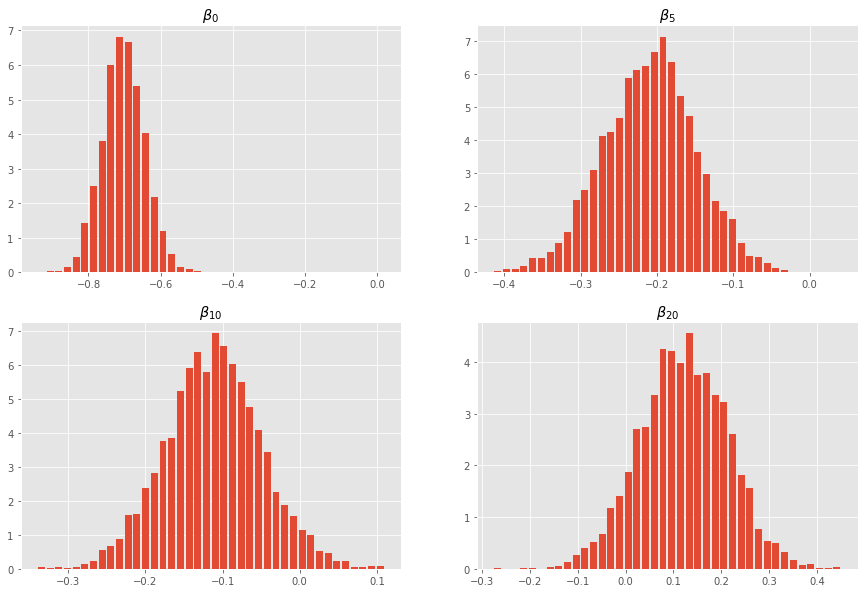

In [111]:
#organisation
nligne = 2
ncol = 2
n_bins = 40
fig = plt.figure(figsize=(15, 10))


index = [0,5, 10, 20]

#plot
plt.style.use('ggplot')
for i, idx in enumerate(index):
    
    plt.subplot(nligne,ncol,i+1)
    plt.hist(beta_GI[:,idx], bins = n_bins, density = True, rwidth = 0.80)
    plt.title("$\\beta_{%d}$" % index[i])

### plot des $z$

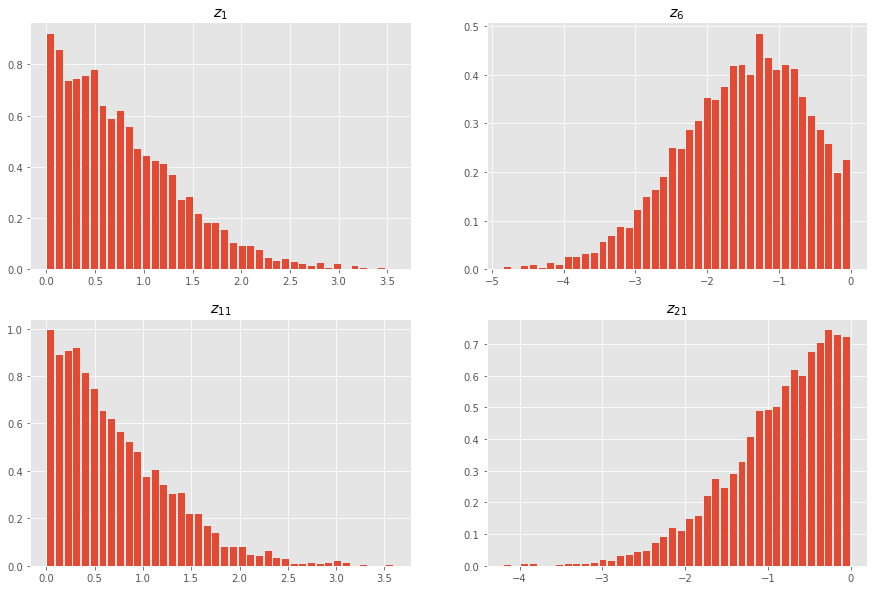

In [112]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(15, 10))
for i in range(len(index)):
    
    plt.subplot(nligne,ncol,i+1)
    plt.hist(z_GI[:,index[i]+1], bins = n_bins, density = True, rwidth = 0.80)
    plt.title('$z_{%d}$' % (index[i]+1))

# Algorithme Mean-Field

In [91]:
def mean_field(X, y, T = 4000, tau = 100):
  
  n = X.shape[0]
  p = X.shape[1]
  cov_q_beta = np.linalg.inv(X.T.dot(X) + (1/tau)*np.eye(p))
  z_norms =[]
  beta_norms = []
  

  beta_mean = np.zeros((T+1,p))

  Z_mean = np.zeros((T+1,n))

  beta = np.zeros((T+1,p))
  Z = np.zeros((T+1,n))

  for i in range(T):
    beta[i+1] = np.random.multivariate_normal( (cov_q_beta @ X.T @ Z_mean[i]), cov_q_beta)
    Z[i+1] = truncated_normal(X @ beta_mean[i] , y) 

    beta_mean[i+1] = cov_q_beta @ X.T @ Z_mean[i]
    Z_mean[i+1] = X @ beta_mean[i] + y * norm.pdf(X @ beta_mean[i]) / norm.cdf(y * (X @ beta_mean[i]))

    z_norms.append(np.linalg.norm(Z_mean[i+1] - Z_mean[i], ord=1))
    beta_norms.append(np.linalg.norm(beta_mean[i+1] - beta_mean[i], ord=1))

  return (beta, Z, beta_norms,z_norms)



## Train

In [108]:
start_time = time.time()

beta_MF, z_MF, beta_norms, Z_norms = mean_field(X_train,y_train)

print("Durée de l'algorithme de mean field: %.3f secondes" % (time.time()-start_time))

Durée de l'algorithme de mean field: 39.343 secondes


## Prédiction 

In [109]:
prédiction(X_test , beta_MF, y_test)

0.795

## Plot

### plot des $\beta$

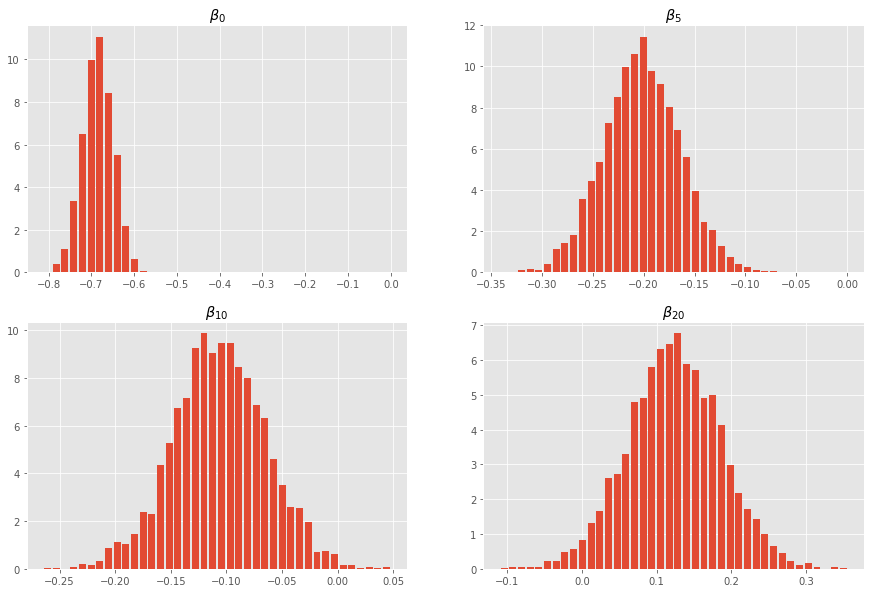

In [113]:
#organisation
ligne = 2
col = 2

index = [0,5, 10, 20]

#plot
plt.style.use('ggplot')
fig = plt.figure(figsize=(15, 10))
for i, idx in enumerate(index):
    
    plt.subplot(ligne,col,i+1)
    plt.hist(beta_MF[:,idx], bins = 50, density = True, rwidth = 0.80)
    plt.title("$\\beta_{%d}$" % index[i])

### Plot des $z$ 

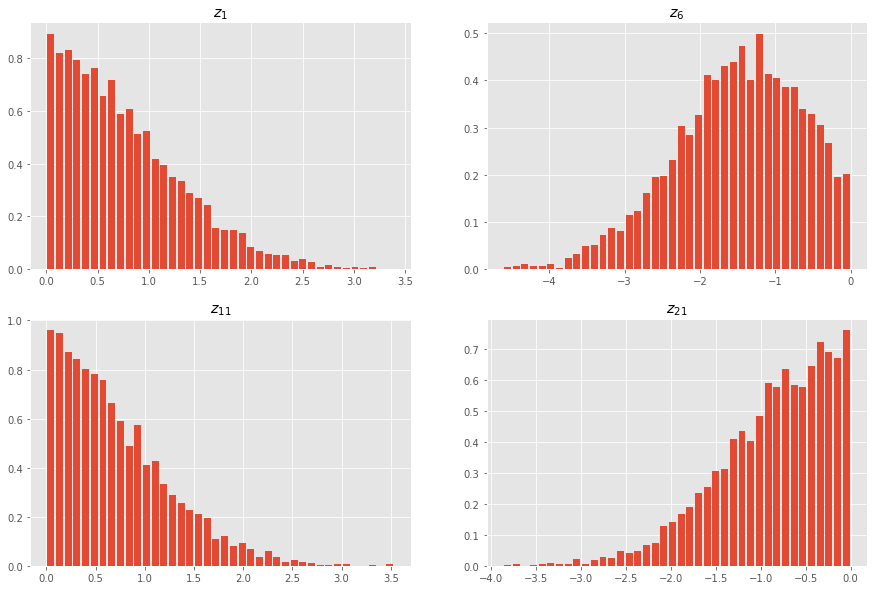

In [114]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(15, 10))
for i in range(len(index)):
    
    plt.subplot(ligne,col,i+1)
    plt.hist(z_MF[:,index[i]+1], bins = 50, density = True, rwidth = 0.80)
    plt.title('$z_{%d}$' % (index[i]+1))

### Plot de comparaison des $\beta$  et $z$ entre les deux algorithmes

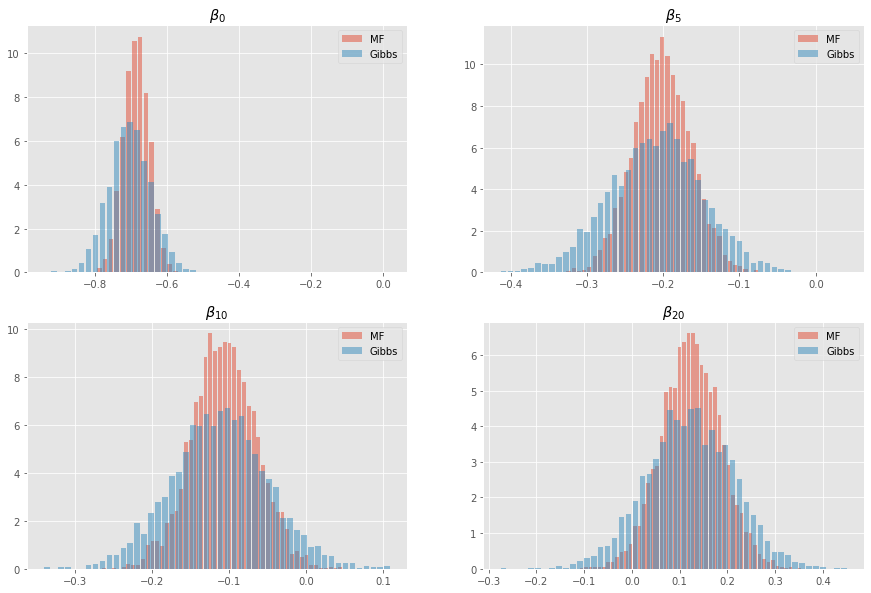

In [187]:
#Organisation
fig = plt.figure(figsize=(15, 10))
ligne = 2
col = 2


#plot
index = [0,5,10,20]
for k, idx in enumerate(index):
    plt.subplot(ligne,col,k+1)
    plt.hist(beta_MF[:, idx], bins=50, alpha=0.5, rwidth=.80, density=True, label="MF");
    plt.hist(beta_GI[:, idx], bins=50, alpha=0.5, rwidth=.80, density=True, label="Gibbs");
    plt.legend()
    plt.title("$\\beta_{%d}$" % idx)


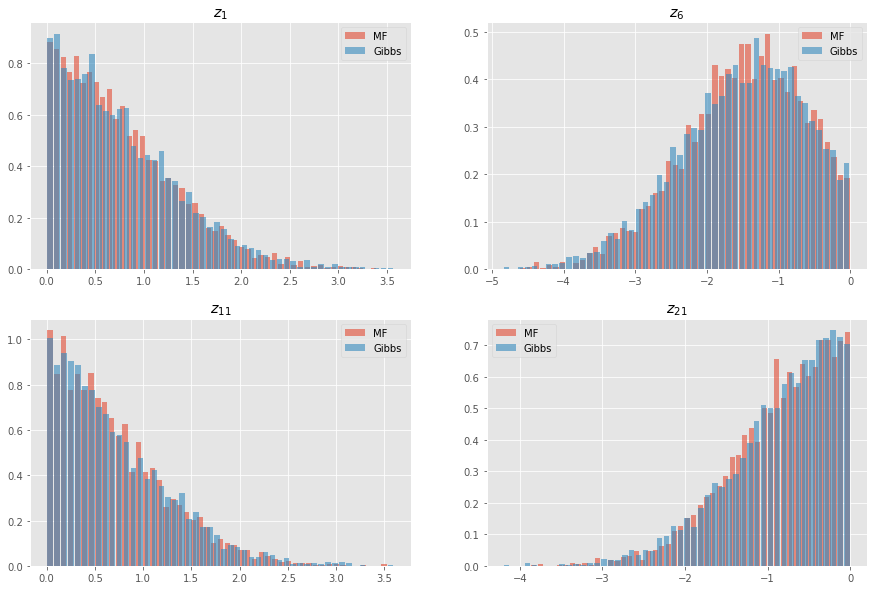

In [128]:
fig = plt.figure(figsize=(15, 10))
for k, idx in enumerate(index):
    plt.subplot(ligne,col,k+1)
    plt.hist(z_MF[:, idx+1], bins=50, alpha=.6, rwidth=.80, density=True, label="MF");
    plt.hist(z_GI[:, idx+1], bins=50, alpha=.6, rwidth=.80, density=True, label="Gibbs");
    plt.legend()
    plt.title("$z_{%d}$" % (idx+1))

# Question 6

In [170]:
k = 1000
dim = 2

x = np.random.randn(k , dim)
beta = np.array([1 , -1])
temp = x @ beta
y1 , x1 , y2 , x2 = [] , [] , [] , []

for i in range(k):
    if temp[i] >0:
        y1.append(1.)
        x1.append(x[i])
    else:
        y2.append(-1.)
        x2.append(x[i])


y1 = np.asarray(y1 , dtype=int)
y2 =np.asarray(y2 , dtype=int)
x1 = np.asarray(x1).reshape(len(y1) , 2)
x2 = np.asarray(x2).reshape(len(y2) , 2) + np.array([0, 1])   #on ajoute un vecteur pour déplacer les variables et rendre les données complètement séparable

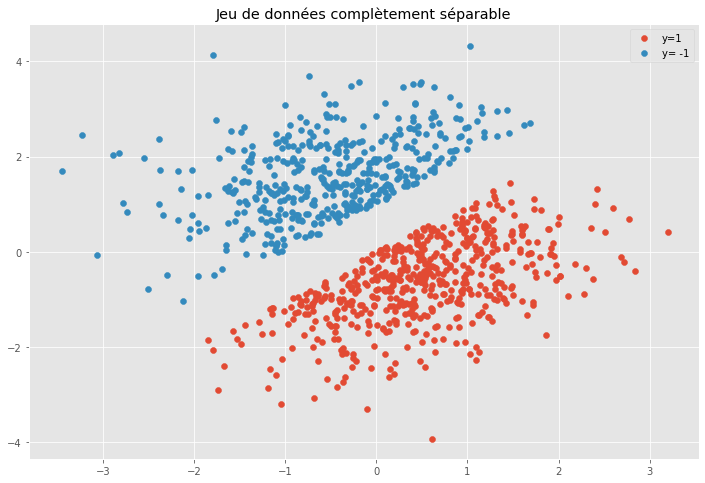

In [188]:
fig = plt.figure(figsize=(12,8))
plt.scatter(*x1.T, label="y=1")
plt.scatter(*x2.T, label="y= -1")
plt.legend()
plt.title("Jeu de données complètement séparable");


## Gibbs variance normale

In [155]:
intercept = (np.ones(len(y1)+len(y2))).reshape(len(y1) + len(y2), 1)
Xbis1 = np.hstack((intercept, np.vstack([x1, x2])))

ybis1 = np.hstack((y1,y2))

In [156]:
Xbis1_train, Xbis1_test, Ybis1_train, Ybis1_test = train_test_split(Xbis1, ybis1, test_size=.2)

In [157]:
zbis_train, betabis_train = Gibbs(Xbis1_train, Ybis1_train, 100)

### Plot des $\beta$

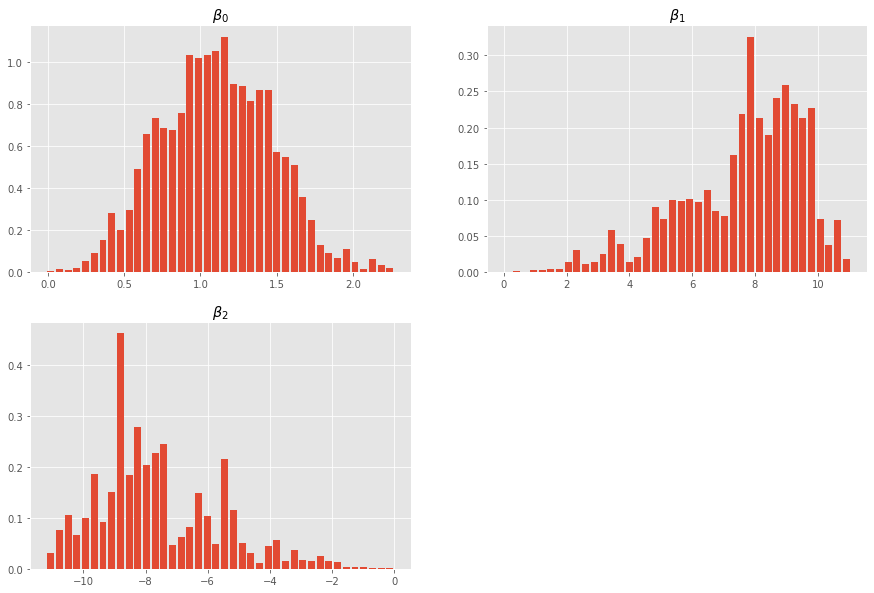

In [158]:
#organisation
nligne = 2
ncol = 2
n_bins = 40
fig = plt.figure(figsize=(15, 10))


index = [0,1,2]

#plot
plt.style.use('ggplot')
for i, idx in enumerate(index):
    
    plt.subplot(nligne,ncol,i+1)
    plt.hist(betabis_train[:,idx], bins = n_bins, density = True, rwidth = 0.80)
    plt.title("$\\beta_{%d}$" % index[i])

In [159]:
prédiction( Xbis1_test, betabis_train,  Ybis1_test)

1.0

## Grande variance 

In [172]:
Xbis2 = np.hstack((intercept, np.vstack([x1, x2])))

In [173]:
Xbis2_train, Xbis2_test, Ybis2_train, Ybis2_test = train_test_split(Xbis2, ybis1, test_size=.2)

In [175]:
zbis2_train, betabis2_train = Gibbs(Xbis2_train, Ybis2_train, 1000, 7000)

### Plot des $\beta$

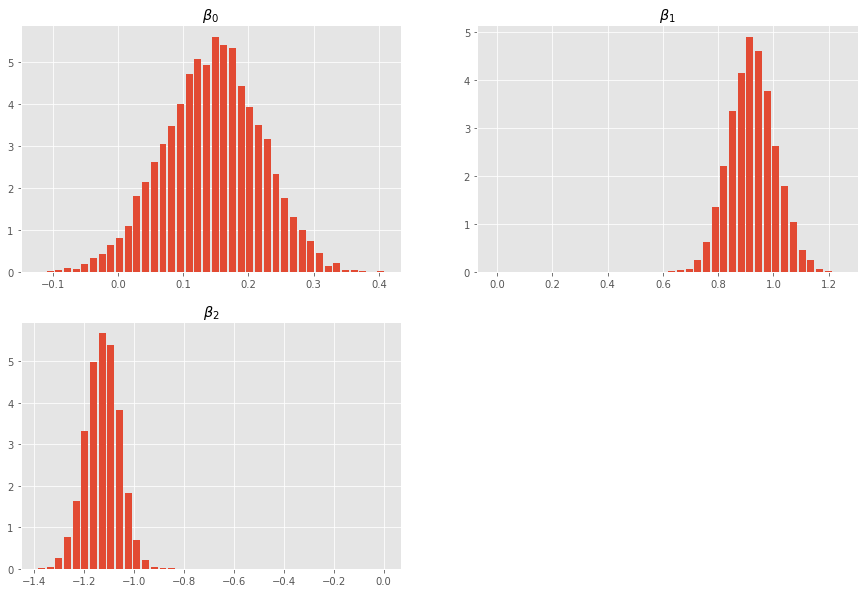

In [176]:
#organisation
nligne = 2
ncol = 2
n_bins = 40
fig = plt.figure(figsize=(15, 10))


index = [0,1,2]

#plot
plt.style.use('ggplot')
for i, idx in enumerate(index):
    
    plt.subplot(nligne,ncol,i+1)
    plt.hist(betabis2_train[:,idx], bins = n_bins, density = True, rwidth = 0.80)
    plt.title("$\\beta_{%d}$" % index[i])

In [177]:
prédiction(Xbis2_test, betabis2_train,Ybis2_test)

0.95